# Idealed Sensitivity Study

Throughout this document *unmodified* is unsed to describe the runs which used the original values of `LANDUSE.TBL`.

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.dates import DateFormatter
from netCDF4 import Dataset
from wrf import (getvar, to_np, vertcross, smooth2d, CoordPair,
                 get_basemap, latlon_coords, g_geoht, combine_files, ALL_TIMES)

# Suppress warnings so the notebook looks nice
import warnings
warnings.filterwarnings('ignore')

# Style for plotting
plt.style.use('default')

# N-ICE Measurements
## NOTE: SEB Measurements are in UTC
### Importing SEB dataset
Measurements_seb = xr.open_dataset('/Users/smurphy/all_datasets/nice_published_datasets/N-ICE_sebData_v1.nc', decode_times = False)

### Longwave radiation into dataframes
M_downlw = pd.DataFrame(Measurements_seb.variables['surface_downwelling_longwave_flux'].values, 
                        index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lw'])
M_uplw = pd.DataFrame(Measurements_seb.variables['surface_upwelling_longwave_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lw'])

### Shortwave radiation into dataframes
M_downsw = pd.DataFrame(Measurements_seb.variables['surface_downwelling_shortwave_flux'].values, 
                        index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['sw'])
M_upsw = pd.DataFrame(Measurements_seb.variables['surface_upwelling_shortwave_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['sw'])

###  Calculating net radiation
M_net = (M_downlw['lw'] - M_uplw['lw']) + (M_downsw['sw'] - M_upsw['sw'])

### Sensible and latent heat flux into dataframes
M_lat = -pd.DataFrame(Measurements_seb.variables['surface_downward_latent_heat_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lh'])
M_sen = -pd.DataFrame(Measurements_seb.variables['surface_downward_sensible_heat_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['sh'])
## NOTE: sensible and latent heat flux negative to match WRF sign convention

# Set date format for plots throughout the notebook
myFmt = DateFormatter("%m/%d \n %H:%M:%S")


# Case 1 - Winter Clear

In [2]:
# Finding all wrfout file
fns = glob('/Volumes/seagate_desktop/idealized/case1/000101/wrfo*')

# Creating an empty list to append to
wrflist = list()

# Opening the wrfout files and appending them to the empty list
for fn in fns:
    wrflist.append(Dataset(fn))

# Defining start and end dates of case study
sdate = '2015-02-04'
edate = '2015-02-06' 

# Creating a mask for the above start and end date to be used later
sebmask = (M_downlw.index > sdate) & (M_downlw.index < edate)

# Importing WRF variables
## dbZ - for cloud plotting
dbz = getvar(wrflist, "dbz", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z = getvar(wrflist, "z").mean('south_north').mean('west_east')
dbz_df = pd.DataFrame(dbz.values, index = dbz.Time.values, columns = z)

## lh - latent heat flux
lh = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df = pd.DataFrame(lh.values, index = lh.Time.values)

## sh - sensible heat flux
sh = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df = pd.DataFrame(sh.values, index = sh.Time.values)

## lwdnb - downwelling longwave radiation
lwdnb = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df = pd.DataFrame(lwdnb.values, index = lwdnb.Time.values)

## lwupb - upwelling longwave radiation
lwupb = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df = pd.DataFrame(lwupb.values, index = lwupb.Time.values)

## swdnb - downwelling shortwave radiation
swdnb = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df = pd.DataFrame(swdnb.values, index = swdnb.Time.values)

## swupb - upwelling shortwave radiation
swupb = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df = pd.DataFrame(swupb.values, index = swupb.Time.values)

## Clouds

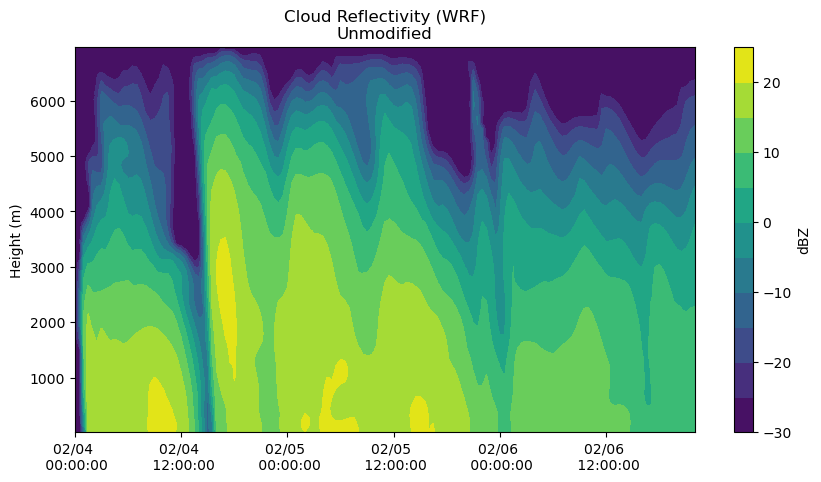

In [15]:
plt.figure(figsize = (10,5))
plt.contourf(dbz_df.index, dbz_df.columns, dbz_df.T.values, levels = 10)
plt.ylabel('Height (m)')
plt.title('Cloud Reflectivity (WRF)\nUnmodified')
plt.colorbar(label = 'dBZ')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

In [57]:
fn = '/Volumes/seagate_desktop/data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150206.cdf'
rbt_cldmask = xr.open_dataset(fn)
measured_cloudmask = pd.DataFrame(rbt_cldmask['CloudMask'].values, index = rbt_cldmask['DataTime'], columns = rbt_cldmask['Range'])
# Time is in UTC time stamp in fractional hours
date_ = fn[-12:-4]


## Sensible and Latent Heat Flux

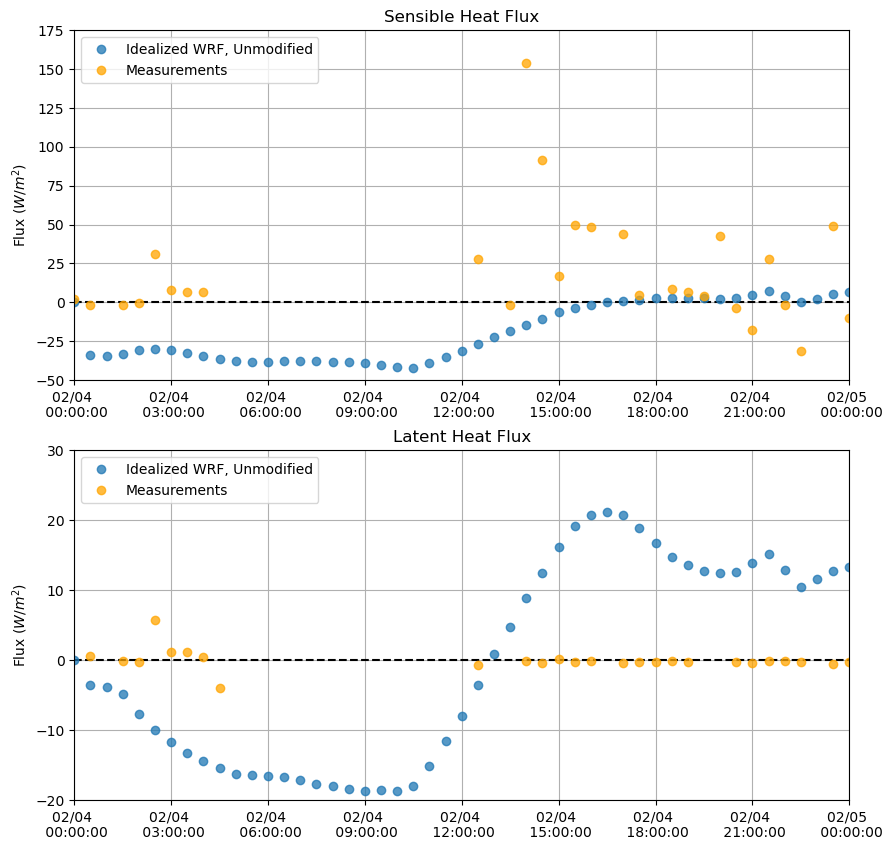

In [18]:
plt.figure(figsize = (10,10))
plt.subplot(211)
plt.plot(sh_df, 'o', alpha = 0.75)
plt.plot(M_sen[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.hlines(0, xmin = sdate, xmax = '2015-05-05', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Sensible Heat Flux')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Measurements'], loc='upper left')
plt.ylim(-50,175)
plt.xlim(sdate,'2015-02-05')
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(212)
plt.plot(lh_df, 'o', alpha = 0.75)
plt.plot(M_lat[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.hlines(0, xmin = sdate, xmax = '2015-02-05', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Latent Heat Flux')
plt.grid()
plt.ylim(-20,30)
plt.legend(['Idealized WRF, Unmodified', 'Measurements'], loc='upper left')
plt.xlim(sdate,'2015-02-05')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

## Longwave Radiation

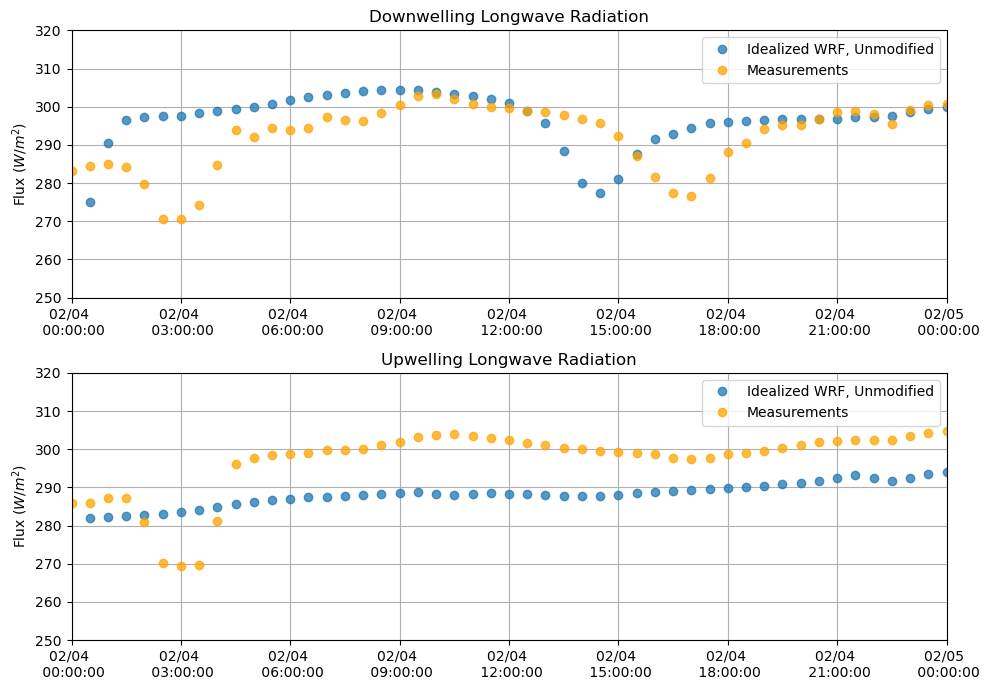

In [20]:
plt.figure(figsize = (10,7))
plt.subplot(211)
plt.plot(lwdnb_df, 'o', alpha = 0.75)
plt.plot(M_downlw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Longwave Radiation')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Measurements'])
plt.ylim(250,320)
plt.xlim(sdate,'2015-02-05')
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(212)
plt.plot(lwupb_df, 'o', alpha = 0.75)
plt.plot(M_uplw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Longwave Radiation')
plt.grid()
plt.ylim(250, 320)
plt.legend(['Idealized WRF, Unmodified', 'Measurements'])
plt.xlim(sdate,'2015-02-05')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.show()

## Summary Table

In [21]:
lwdns = M_downlw[sdate:edate]
lwdns.columns = ['measured']
lwdns['unmodified'] = lwdnb_df[0]

lwups = M_uplw[sdate:edate]
lwups.columns = ['measured']
lwups['unmodified'] = lwupb_df[0]

swdns = M_downsw[sdate:edate]
swdns.columns = ['measured']
swdns['unmodified'] = swdnb_df[0]

swups = M_upsw[sdate:edate]
swups.columns = ['measured']
swups['unmodified'] = swupb_df[0]

lhs = M_lat[sdate:edate]
lhs.columns = ['measured']
lhs['unmodified'] = lh_df[0]

shs = M_sen[sdate:edate]
shs.columns = ['measured']
shs['unmodified'] = sh_df[0]

In [22]:
correlation_coefficients = pd.DataFrame([lhs.corr()['measured'].values, 
                                         shs.corr()['measured'].values,
                                         lwdns.corr()['measured'].values,
                                         lwups.corr()['measured'].values], 
                                         columns = lhs.corr().columns,
                                         index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave']).T
r_squared = correlation_coefficients ** 2
r_squared.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'pink', axis = 0)

,Latent,Sensible,Downwelling Longwave,Upwelling Longwave
measured,1.000000,1.000000,1.000000,1.000000
unmodified,0.000060,0.022658,0.715887,0.614063


# Case 2 - Spring Cloudy

In [62]:
fns = glob('/Volumes/seagate_desktop/idealized/case4/000101/wrfo*')
wrflist = list()
for fn in fns:
    wrflist.append(Dataset(fn))
    
sdate = '2015-05-02'
edate = '2015-05-04' 

sebmask = (M_downlw.index > sdate) & (M_downlw.index < edate)

dbz = getvar(wrflist, "dbz", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z = getvar(wrflist, "z").mean('south_north').mean('west_east')
dbz_df = pd.DataFrame(dbz.values, index = dbz.Time.values, columns = z)

lh = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df = pd.DataFrame(lh.values, index = lh.Time.values)

sh = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df = pd.DataFrame(sh.values, index = sh.Time.values)

lwdnb = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df = pd.DataFrame(lwdnb.values, index = lwdnb.Time.values)

lwupb = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df = pd.DataFrame(lwupb.values, index = lwupb.Time.values)

swdnb = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df = pd.DataFrame(swdnb.values, index = swdnb.Time.values)

swupb = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df = pd.DataFrame(swupb.values, index = swupb.Time.values)

## Clouds

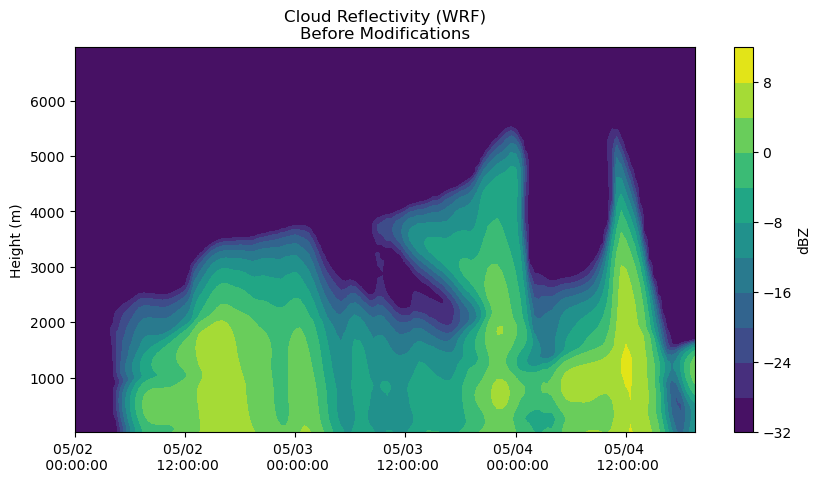

In [63]:
plt.figure(figsize = (10,5))
plt.contourf(dbz_df.index, dbz_df.columns, dbz_df.T.values, levels = 10)
plt.ylabel('Height (m)')
plt.title('Cloud Reflectivity (WRF)\nBefore Modifications')
plt.colorbar(label = 'dBZ')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

## Sensible and Latent Heat Flux

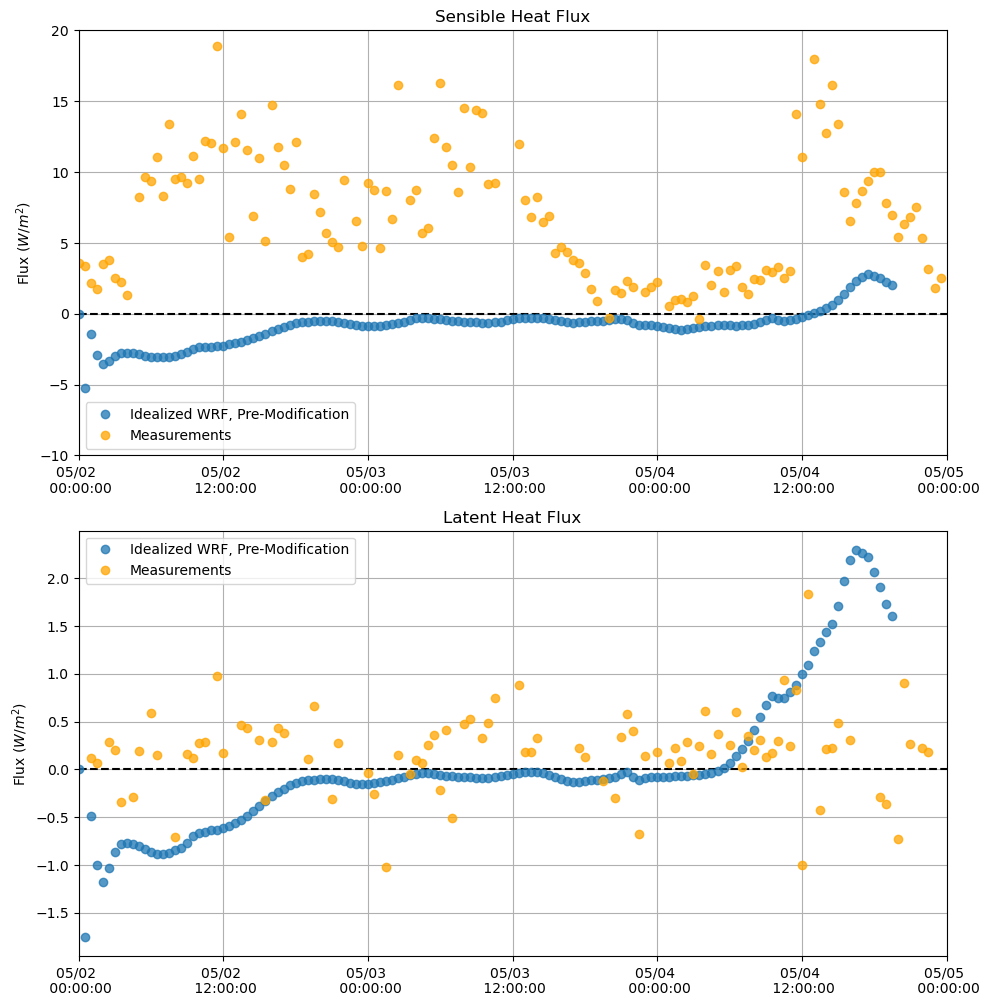

In [67]:
plt.figure(figsize = (10,10))
plt.subplot(211)
plt.plot(sh_df, 'o', alpha = 0.75)
plt.plot(M_sen[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.hlines(0, xmin = sdate, xmax = '2015-05-05', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Sensible Heat Flux')
plt.grid()
plt.legend(['Idealized WRF, Pre-Modification', 'Measurements'])
plt.ylim(-10,20)
plt.xlim(sdate,'2015-05-05')
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(212)
plt.plot(lh_df, 'o', alpha = 0.75)
plt.plot(M_lat[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.hlines(0, xmin = sdate, xmax = '2015-05-05', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Latent Heat Flux')
plt.grid()
plt.legend(['Idealized WRF, Pre-Modification', 'Measurements'])
plt.xlim(sdate,'2015-05-05')
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

## Longwave and Shortwave Radiation

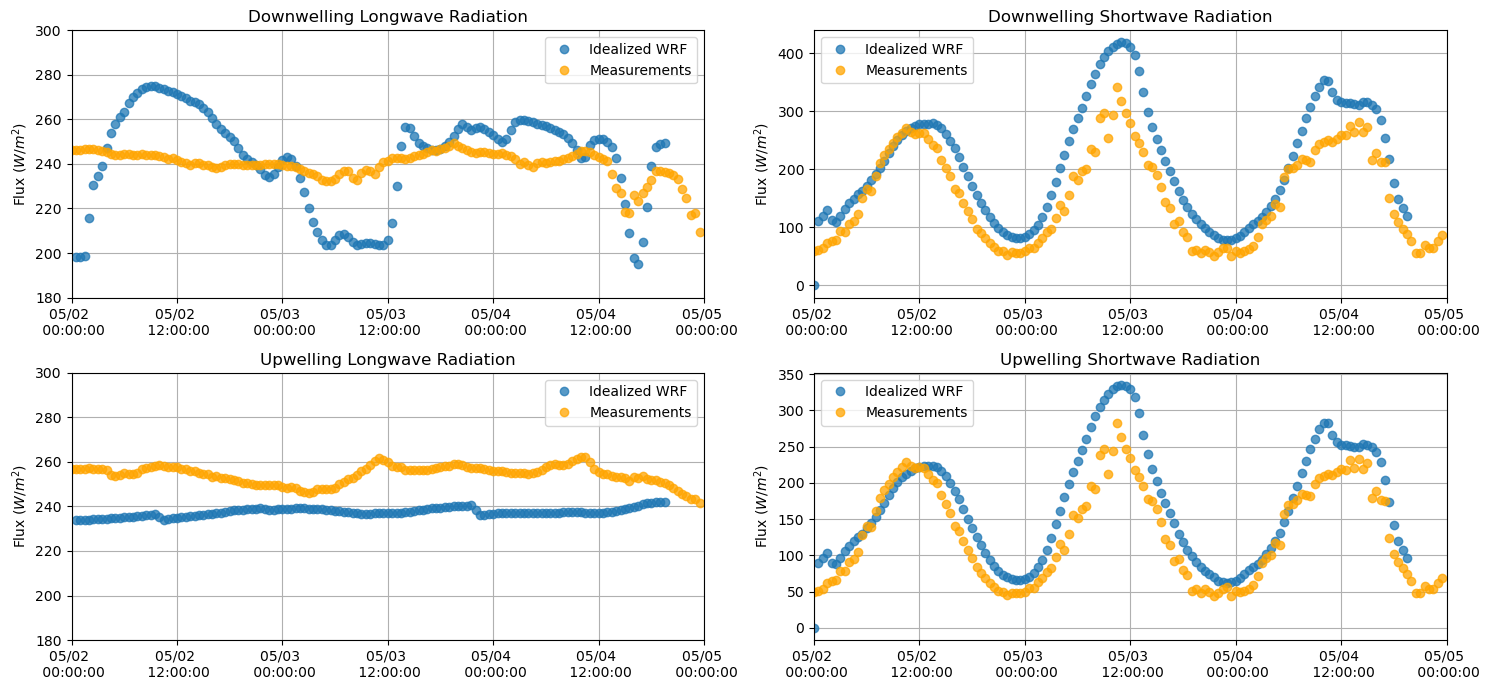

In [68]:
plt.figure(figsize = (15,7))
plt.subplot(221)
plt.plot(lwdnb_df, 'o', alpha = 0.75)
plt.plot(M_downlw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Longwave Radiation')
plt.grid()
plt.legend(['Idealized WRF', 'Measurements'])
plt.ylim(180,300)
plt.xlim(sdate,'2015-05-05')
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(223)
plt.plot(lwupb_df, 'o', alpha = 0.75)
plt.plot(M_uplw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Longwave Radiation')
plt.grid()
plt.ylim(180, 300)
plt.legend(['Idealized WRF', 'Measurements'])
plt.xlim(sdate,'2015-05-05')
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(222)
plt.plot(swdnb_df, 'o', alpha = 0.75)
plt.plot(M_downsw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Shortwave Radiation')
plt.grid()
plt.legend(['Idealized WRF', 'Measurements'])
#plt.ylim(180,300)
plt.xlim(sdate,'2015-05-05')
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(224)
plt.plot(swupb_df, 'o', alpha = 0.75)
plt.plot(M_upsw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Shortwave Radiation')
plt.grid()
#plt.ylim(180, 300)
plt.legend(['Idealized WRF', 'Measurements'])
plt.xlim(sdate,'2015-05-05')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.show()

## Summary Table

In [69]:
lwdns = M_downlw[sdate:edate]
lwdns.columns = ['measured']
lwdns['unmodified'] = lwdnb_df[0]

lwups = M_uplw[sdate:edate]
lwups.columns = ['measured']
lwups['unmodified'] = lwupb_df[0]

swdns = M_downsw[sdate:edate]
swdns.columns = ['measured']
swdns['unmodified'] = swdnb_df[0]

swups = M_upsw[sdate:edate]
swups.columns = ['measured']
swups['unmodified'] = swupb_df[0]

lhs = M_lat[sdate:edate]
lhs.columns = ['measured']
lhs['unmodified'] = lh_df[0]

shs = M_sen[sdate:edate]
shs.columns = ['measured']
shs['unmodified'] = sh_df[0]

In [70]:
correlation_coefficients = pd.DataFrame([lhs.corr()['measured'].values, 
                                         shs.corr()['measured'].values,
                                         lwdns.corr()['measured'].values,
                                         lwups.corr()['measured'].values], 
                                         columns = lhs.corr().columns,
                                         index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave']).T
r_squared = correlation_coefficients ** 2
r_squared.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'pink', axis = 0)

,Latent,Sensible,Downwelling Longwave,Upwelling Longwave
measured,1.000000,1.000000,1.000000,1.000000
unmodified,0.001381,0.005242,0.091075,0.006432


# Case 3 - Spring Clear

In [ ]:
sdate = '2015-05-22'
edate = '2015-05-25' 

M_net = (M_downlw['lw'] - M_uplw['lw'])
sebmask = (M_downlw.index > sdate) & (M_downlw.index < edate)

fns = glob('/Volumes/seagate_desktop/idealized/case3/000101/wrfo*')
wrflist = list()
for fn in fns:
    wrflist.append(Dataset(fn))
    
dbz = getvar(wrflist, "dbz", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z = getvar(wrflist, "z").mean('south_north').mean('west_east')
dbz_df = pd.DataFrame(dbz.values, index = dbz.Time.values, columns = z)

lh = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df = pd.DataFrame(lh.values, index = lh.Time.values)

sh = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df = pd.DataFrame(sh.values, index = sh.Time.values)

lwdnb = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df = pd.DataFrame(lwdnb.values, index = lwdnb.Time.values)

lwupb = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df = pd.DataFrame(lwupb.values, index = lwupb.Time.values)

swdnb = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df = pd.DataFrame(swdnb.values, index = swdnb.Time.values)

swupb = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df = pd.DataFrame(swupb.values, index = swupb.Time.values)

## Clouds

In [ ]:
plt.figure(figsize = (10,5))
plt.contourf(dbz_df.index, dbz_df.columns, dbz_df.T.values, levels = 10)
plt.ylabel('Height (m)')
plt.title('Cloud Reflectivity (WRF)\nBefore Modifications')
plt.colorbar(label = 'dBZ')
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

## Sensible and Latent Heat Flux

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(211)
plt.plot(sh_df, 'o', alpha = 0.75)
plt.plot(M_sen[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.hlines(0, xmin = sdate, xmax = '2015-05-25', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Sensible Heat Flux')
plt.grid()
plt.legend(['Idealized WRF, Pre-Modification', 'Measurements'])
#plt.ylim(-10,20)
plt.xlim(sdate,'2015-05-25')
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(212)
plt.plot(lh_df, 'o', alpha = 0.75)
plt.plot(M_lat[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.hlines(0, xmin = sdate, xmax = '2015-05-25', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Latent Heat Flux')
plt.grid()
plt.legend(['Idealized WRF, Pre-Modification', 'Measurements'])
plt.xlim(sdate,'2015-05-25')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.show()

## Longwave and Shortwave Radiation

In [ ]:
plt.figure(figsize = (15,7))
plt.subplot(221)
plt.plot(lwdnb_df, 'o', alpha = 0.75)
plt.plot(M_downlw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Longwave Radiation')
plt.grid()
plt.legend(['Idealized WRF', 'Measurements'])
plt.ylim(150,300)
plt.xlim(sdate,'2015-05-25')
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(223)
plt.plot(lwupb_df, 'o', alpha = 0.75)
plt.plot(M_uplw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Longwave Radiation')
plt.grid()
plt.ylim(240,300)
plt.legend(['Idealized WRF', 'Measurements'])
plt.xlim(sdate,'2015-05-25')
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(222)
plt.plot(swdnb_df, 'o', alpha = 0.75)
plt.plot(M_downsw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Shortwave Radiation')
plt.grid()
plt.ylim(50, 600)
plt.legend(['Idealized WRF', 'Measurements'])
plt.xlim(sdate,'2015-05-25')
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(224)
plt.plot(swupb_df, 'o', alpha = 0.75)
plt.plot(M_upsw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Shortwave Radiation')
plt.grid()
plt.ylim(50, 500)
plt.legend(['Idealized WRF', 'Measurements'])
plt.xlim(sdate,'2015-05-25')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.show()

## Summary Table

In [ ]:
lwdns = M_downlw[sdate:edate]
lwdns.columns = ['measured']
lwdns['unmodified'] = lwdnb_df[0]

lwups = M_uplw[sdate:edate]
lwups.columns = ['measured']
lwups['unmodified'] = lwupb_df[0]

swdns = M_downsw[sdate:edate]
swdns.columns = ['measured']
swdns['unmodified'] = swdnb_df[0]

swups = M_upsw[sdate:edate]
swups.columns = ['measured']
swups['unmodified'] = swupb_df[0]

lhs = M_lat[sdate:edate]
lhs.columns = ['measured']
lhs['unmodified'] = lh_df[0]

shs = M_sen[sdate:edate]
shs.columns = ['measured']
shs['unmodified'] = sh_df[0]

In [ ]:
correlation_coefficients = pd.DataFrame([lhs.corr()['measured'].values, 
                                         shs.corr()['measured'].values,
                                         lwdns.corr()['measured'].values,
                                         lwups.corr()['measured'].values], 
                                         columns = lhs.corr().columns,
                                         index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave']).T
r_squared = correlation_coefficients ** 2
r_squared.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'pink', axis = 0)

## Statistics and Summary